In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [148]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [149]:
print('training data length %s'% len(training_data))
print('testing data length %s'%len(test_data))

training data length 60000
testing data length 10000


In [150]:
batch_size = 64

# Create data loaders.
train_loader = DataLoader(training_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


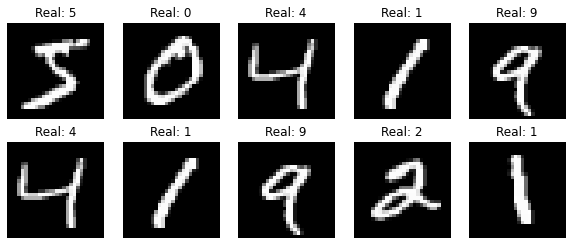

In [151]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        idx = 2*i+j
        axs[i][j].imshow(training_data[idx][0][0], cmap='gray', interpolation='none')
        axs[i][j].set_title("Real: {}".format(training_data[idx][1]))
        axs[i][j].axis('off')

In [152]:
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self,num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.classifiers = []
        
        for i in range(num_classes):
            proj = nn.Sequential(
                nn.Linear(32*6*6, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid())
            self.classifiers.append(proj)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 32*6*6)
        
        out = []
        for i in range(self.num_classes):
            out.append(self.classifiers[i](x))
        return out


In [153]:
class ContrastiveLoss(nn.Module):
    
    def __init__(self, temperature=0.07, contrast_mode='all',base_temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        
    def forward(self, predictions, labels=None, mask=None):
        device = (torch.device('cuda') if predictions.is_cuda else torch.device('cpu'))
        
        losses = []
        for features in predictions:
            batch_size = features.shape[0]
            if labels is not None and mask is not None:
                raise ValueError('Cannot define both `labels` and `mask`')
            elif labels is None and mask is None:
                mask = torch.eye(batch_size, dtype=torch.float32).to(device)
            elif labels is not None:
                labels = labels.contiguous().view(-1, 1)
                if labels.shape[0] != batch_size:
                    raise ValueError('Num of labels does not match num of features')
                mask = torch.eq(labels, labels.T).float().to(device)
            else:
                mask = mask.float().to(device)

            contrast_count = features.shape[1]
            contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
            if self.contrast_mode == 'one':
                anchor_feature = features[:, 0]
                anchor_count = 1
            elif self.contrast_mode == 'all':
                anchor_feature = contrast_feature
                anchor_count = contrast_count
            else:
                raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

            # compute logits
            anchor_dot_contrast = torch.div(
                torch.matmul(anchor_feature, contrast_feature.T),
                self.temperature)
            # for numerical stability
            logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
            logits = anchor_dot_contrast - logits_max.detach()

            # tile mask
            mask = mask.repeat(anchor_count, contrast_count)
            # mask-out self-contrast cases
            logits_mask = torch.scatter(
                torch.ones_like(mask),
                1,
                torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
                0
            )
            mask = mask * logits_mask

            # compute log_prob
            exp_logits = torch.exp(logits) * logits_mask
            log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

            # compute mean of log-likelihood over positive
            mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

            # loss
            loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
            loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [154]:
torch.ones_like(mask)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [188]:
features = torch.tensor([[0.4,0.6],[0.5,0.5],[0.7,0.3],[0.2,0.8]])
print(features)
print(torch.unbind(features, dim=1))
contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
print(contrast_feature)

tensor([[0.4000, 0.6000],
        [0.5000, 0.5000],
        [0.7000, 0.3000],
        [0.2000, 0.8000]])
(tensor([0.4000, 0.5000, 0.7000, 0.2000]), tensor([0.6000, 0.5000, 0.3000, 0.8000]))
tensor([0.4000, 0.5000, 0.7000, 0.2000, 0.6000, 0.5000, 0.3000, 0.8000])


In [194]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

In [195]:
features.shape

torch.Size([4, 2])

In [196]:
features.T.shape

torch.Size([2, 4])

In [197]:
cos(features, features)

tensor([1., 1.])

In [156]:
print(features)
f1,f2=torch.split(features, [2,2], dim=0)
features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
print(features)

tensor([[0.4000, 0.6000],
        [0.5000, 0.5000],
        [0.7000, 0.3000],
        [0.2000, 0.8000]])
tensor([[[0.4000, 0.6000],
         [0.7000, 0.3000]],

        [[0.5000, 0.5000],
         [0.2000, 0.8000]]])


In [157]:
print(torch.unbind(features, dim=1))
contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
print(contrast_feature)

(tensor([[0.4000, 0.6000],
        [0.5000, 0.5000]]), tensor([[0.7000, 0.3000],
        [0.2000, 0.8000]]))
tensor([[0.4000, 0.6000],
        [0.5000, 0.5000],
        [0.7000, 0.3000],
        [0.2000, 0.8000]])


In [158]:
anchor_feature = contrast_feature
contrast_count = 2
anchor_count = 2

In [159]:
anchor_dot_contrast = torch.div(torch.matmul(anchor_feature, contrast_feature.T),0.7)
print(anchor_dot_contrast)

tensor([[0.7429, 0.7143, 0.6571, 0.8000],
        [0.7143, 0.7143, 0.7143, 0.7143],
        [0.6571, 0.7143, 0.8286, 0.5429],
        [0.8000, 0.7143, 0.5429, 0.9714]])


In [160]:
logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
print(logits_max.detach())

tensor([[0.8000],
        [0.7143],
        [0.8286],
        [0.9714]])


In [161]:
logits = anchor_dot_contrast - logits_max.detach()
print(logits)

tensor([[-0.0571, -0.0857, -0.1429,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1714, -0.1143,  0.0000, -0.2857],
        [-0.1714, -0.2571, -0.4286,  0.0000]])


In [162]:
labels = torch.tensor([[1.,2.]])
labels = labels.contiguous().view(-1, 1)
print(labels)
mask = torch.eq(labels, labels.T).float()
print(mask)
mask = mask.repeat(anchor_count, contrast_count)
print(mask)

tensor([[1.],
        [2.]])
tensor([[1., 0.],
        [0., 1.]])
tensor([[1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.]])


In [163]:
logits.sum(1)

tensor([-0.2857,  0.0000, -0.5714, -0.8571])

In [164]:
logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(2 * 2).view(-1, 1).to('cpu'),
            0
        )
print(logits_mask)

tensor([[0., 1., 1., 1.],
        [1., 0., 1., 1.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.]])


In [165]:
mask = mask * logits_mask

In [166]:
print(mask)

tensor([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]])


In [167]:
exp_logits = torch.exp(logits) * logits_mask
print(exp_logits)
print(exp_logits.sum(1, keepdim=True))
log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
print(log_prob)

tensor([[0.0000, 0.9179, 0.8669, 1.0000],
        [1.0000, 0.0000, 1.0000, 1.0000],
        [0.8425, 0.8920, 0.0000, 0.7515],
        [0.8425, 0.7733, 0.6514, 0.0000]])
tensor([[2.7847],
        [3.0000],
        [2.4859],
        [2.2672]])
tensor([[-1.0813, -1.1099, -1.1670, -1.0242],
        [-1.0986, -1.0986, -1.0986, -1.0986],
        [-1.0821, -1.0249, -0.9107, -1.1964],
        [-0.9900, -1.0757, -1.2471, -0.8185]])


In [168]:
mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
print(mean_log_prob_pos)

tensor([-1.1670, -1.0986, -1.0821, -1.0757])


In [169]:
loss = - (0.7 / 0.3) * mean_log_prob_pos
print(loss)

tensor([2.7230, 2.5634, 2.5249, 2.5099])


In [170]:
print(loss.mean())

tensor(2.5803)


In [171]:
print(loss.view(2, 2))
loss = loss.view(2, 2).mean()
print(loss)

tensor([[2.7230, 2.5634],
        [2.5249, 2.5099]])
tensor(2.5803)


In [172]:
learning_rate = 0.01
momentum = 0.5
log_interval = 50
n_epochs = 3

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

TypeError: __init__() missing 1 required positional argument: 'num_classes'

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

In [177]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(target)
    break

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])


In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [173]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

In [174]:
from torchvision import transforms, datasets

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=128, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])


train_dataset = datasets.MNIST(root="data",transform=TwoCropTransform(train_transform),download=True)


In [175]:
train_dataset[0]

([tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  tensor([[[0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
           [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
           [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
           ...,
           [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
           [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
           [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196]]])],
 5)

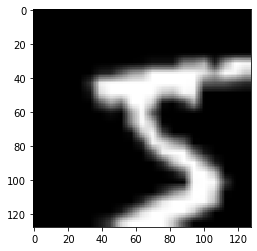

In [61]:
plt.imshow(train_dataset[0][0][0][0], cmap='gray', interpolation='none')

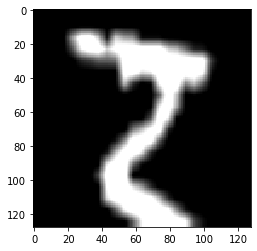

In [62]:
train_dataset[0][0][1][0]
# print(train_dataset[0][0][0][0].shape)
plt.imshow(train_dataset[0][0][1][0], cmap='gray', interpolation='none')

In [64]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [66]:
for idx, (images, labels) in enumerate(train_loader):
    print(images[0].shape)
    print(images[0])
    images = torch.cat([images[0], images[1]], dim=0)
    print(images.shape)
    print(images)
    break

torch.Size([64, 1, 128, 128])
tensor([[[[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          ...,
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        

In [198]:
tensor1 = torch.randn(3,4)
tensor2 = torch.randn(3,4)
cos = torch.nn.CosineSimilarity(dim=0)
cos(tensor1, tensor2)

tensor([ 0.3697, -0.9209, -0.0408, -0.7380])

In [204]:
c = torch.tensor([[ 1, 2, 3],[-1, 1, 4]] , dtype= torch.float)
print(c)
z = torch.norm(c, dim=1,keepdim=True)
print(z)

tensor([[ 1.,  2.,  3.],
        [-1.,  1.,  4.]])
tensor([[3.7417],
        [4.2426]])


In [203]:
torch.matmul(z, z.T)

tensor([[14.0000, 15.8745],
        [15.8745, 18.0000]])

In [5]:
a = torch.ones_like(torch.rand(5,5))
a.scatter_(1, targets.unsqueeze(-1), 1)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [20]:
labels = torch.tensor([1,0,1,0,0])
labels = labels.view(-1, 1)
torch.logical_and(labels, labels.T).float()

tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [22]:
labels = torch.tensor([1,0,1,0,0])
labels.nonzero().detach()
# labels[labels.nonzero().detach()]

tensor([[0],
        [2]])

In [24]:
torch.unique(labels,return_counts=True)

(tensor([0, 1]), tensor([3, 2]))

In [151]:
target = torch.randint(10, (256, ))
anchor = 0
labels = target.numpy()
# print(labels)
num_classes = 10
batch_size = 256

idx = np.where(labels == anchor)[0]
each_class = batch_size/num_classes
each_sub_div = each_class//(each_class/(num_classes-1))
each_sub_div = int(each_sub_div - 1)

print(each_sub_div)

print(len(idx))
for i in range(10):
    if i == anchor:
        continue
    sub_idx = np.where(labels == i)[0]
    np.random.shuffle(sub_idx)
    
    if len(sub_idx) > each_sub_div:
        sub_idx = sub_idx[:round(len(sub_idx)/each_sub_div)]
    idx = np.concatenate((idx, sub_idx), axis=0)
print(idx)
print(len(idx))
#     np.random.shuffle(arr)
# idx = ((labels == 1).nonzero(as_tuple=True)[0])

8
32
[  9  10  13  20  27  33  34  52  55  62  83 101 109 111 117 119 135 137
 140 154 156 157 158 160 163 181 182 189 200 216 235 243 252 244  35  61
  66  43 171 116  18 232   2 130 227  51 180   7  30 245 253  94 151 255
 166 147 221 239  75 122  39]
61


In [152]:
target[idx]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5,
        5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9])

In [141]:
print(labels)
print(idx)

[7 6 0 6 3 9 5 2 2 9 5 4 7 0 7 0 4 8 6 9 2 5 5 2 7 4 9 0 1 7 3 5 9 1 8 3 6
 3 4 2 0 6 4 5 0 3 5 7 1 4 1 2 5 1 1 5 6 3 9 4 9 5 7 0 9 5 6 4 5 1 5 3 4 8
 0 0 8 1 2 2 7 4 2 3 9 2 0 1 5 2 2 0 1 0 1 5 8 3 4 9 5 1 2 6 0 7 9 9 9 0 1
 8 1 6 4 1 0 2 4 3 9 2 3 9 9 5 3 1 3 9 5 8 7 9 8 2 4 6 4 3 5 8 4 7 4 7 7 5
 0 0 9 7 8 0 3 5 4 7 1 0 9 2 2 3 5 4 8 3 3 7 0 4 0 6 1 1 5 8 6 6 9 9 6 5 1
 4 6 9 4 0 2 0 9 4 5 2 8 4 0 2 9 8 2 3 4 0 5 4 5 6 1 6 3 6 4 4 2 6 1 7 7 6
 7 6 8 7 7 5 3 2 0 3 1 6 8 7 8 2 0 5 5 0 4 8 1 6 2 4 0 6 2 2 8 7 2 8]
[  2  13  15  27  40  44  63  74  75  86  91  93 104 109 116 148 149 153
 159 170 172 189 191 198 205 230 238 241 248 232  50  33   7  51 229 231
 212 247 156  25 227  43 240  18  36 217 222  80 224 201 123 200  26]


In [96]:
import numpy as np
idx_a = idx.numpy()
np.random.shuffle(idx_a)

In [97]:
print(idx_a)

[6 4]


In [82]:
sub_idx = len(idx)//3
print(sub_idx)
sub_idx = torch.randperm(len(idx))[:sub_idx]
print(labels[sub_idx])

1
tensor([3])


In [83]:
idx_2 = ((labels == 2).nonzero(as_tuple=True)[0])
sub_idx_2 = len(idx_2)//2
print(sub_idx_2)
sub_idx_2 = torch.randperm(len(idx_2))[:sub_idx_2]
print(labels[sub_idx_2])

1
tensor([7])


In [84]:
print(sub_idx,sub_idx_2)

tensor([1]) tensor([0])


In [87]:
torch.cat([sub_idx,sub_idx_2])

tensor([1, 0])

In [155]:
target = torch.randint(10, (256, ))
target.view(-1,1)

tensor([[7],
        [1],
        [6],
        [4],
        [7],
        [8],
        [2],
        [0],
        [0],
        [9],
        [6],
        [4],
        [1],
        [7],
        [2],
        [2],
        [8],
        [7],
        [1],
        [1],
        [9],
        [2],
        [4],
        [2],
        [6],
        [1],
        [2],
        [7],
        [5],
        [0],
        [6],
        [1],
        [2],
        [3],
        [8],
        [9],
        [0],
        [2],
        [3],
        [4],
        [6],
        [9],
        [5],
        [0],
        [9],
        [0],
        [3],
        [9],
        [6],
        [2],
        [7],
        [5],
        [2],
        [5],
        [0],
        [1],
        [7],
        [3],
        [7],
        [2],
        [0],
        [3],
        [0],
        [4],
        [6],
        [4],
        [3],
        [6],
        [7],
        [0],
        [8],
        [8],
        [4],
        [2],
        [7],
        [7],
        [1],